# Customer Segmentation and Market Analysis

## Introduction
<br>
<div style="text-align: justify">This project focuses on the exploration of customer segmentation through the use of machine learning techniques. We leverage a dataset from an online retail business based in the UK that operates without a physical storefront. The dataset spans from December 1, 2010, to December 9, 2011, providing a comprehensive view of transactions during this period.</div>

### Objective:
1. **Customer Segmentation**: To group customers into distinct categories based on purchasing behavior.
2. **Association Rule Mining**: Discover interesting purchasing patterns and relationships among products. This can be particularly useful for strategies like market basket analysis.

By the end of this project, we aim to derive actionable insights that can assist the business in tailoring marketing strategies, making inventory decisions, and enhancing the overall customer shopping experience.


---

**Note**: For visualization, we will utilize `seaborn` for its elegance and simplicity. However, for more interactive and complex visualizations, `dash` might be considered as part of the project's extension.

---



### Imports

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Customer Segmentation
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# Time Series Analysis and Forecasting
from statsmodels.tsa.seasonal import seasonal_decompose

# Anomaly Detection
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Customer Lifetime Value Prediction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Churn Prediction
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Optimizing Marketing Strategies
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import precision_score, recall_score, f1_score

# Settings for better visualization
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

### Loading Data

In [2]:
df = pd.read_csv("Customer_Segmentation.csv")
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01.12.10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01.12.10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.10 08:26,3.39,17850.0,United Kingdom


**Description of each column:**

**InvoiceNo:** A unique identifier for the invoice. An invoice number shared across rows means that those transactions were performed in a single invoice (multiple purchases).<br>
**StockCode:** Identifier for items contained in an invoice.<br>
**Description:** Textual description of each of the stock item.<br>
**Quantity:** The quantity of the item purchased.<br>
**InvoiceDate:** Date & time of purchase.<br>
**UnitPrice:** Value of each item.<br>
**CustomerID:** Identifier for customer making the purchase.<br>
**Country:** Country of customer.<br>

### Describe Data

In [3]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Initial Analysis

**Missing Data:** There's a discrepancy between the total number of records (541,909) and the count of available CustomerIDs (406,829). This suggests missing data for some transactions.<br>
**Anomalies in Quantity & Price:** The presence of negative values in both Quantity and UnitPrice indicates possible refunds or data errors. These need to be investigated further.<br>
**Variability:** There's a wide range of quantities and prices, suggesting a diverse set of products and transactions.<br>
**Standardization:** Before applying machine learning algorithms, especially distance-based ones like clustering, the data will need to be standardized to have a mean of 0 and a standard deviation of 1. This is especially important given the wide range of values in the dataset.<br><br>

Next steps would involve cleaning the data (handling missing values, dealing with negative quantities and prices), visualizing the data for better understanding, and then proceeding with the desired analyses.

# Data Preprocessing

### Data Cleaning

In [4]:
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_values

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

The missing values in the dataset are as follows:

**Description:** 1454 missing values<br>
**CustomerID:** 1,35,080 missing values<br><br>

For the Description column, since there are only 12 missing values, we can decide to either drop these rows or replace them with a placeholder like "Unknown".<br>

For the CustomerID column, the absence of a customer ID could mean that these were guest checkouts or the ID was not captured due to some reason. Considering them as guest checkouts, we will replace missing IDs with a placeholder ID '9999'. 

In [5]:
# Drop rows with missing 'Description'
df = df.dropna(subset=['Description'])

# Replace missing 'CustomerID' with '9999' (Guest Checkout)
df['CustomerID'].fillna(9999, inplace=True)

# Check if there are any more missing values
missing_values = df.isnull().sum()
missing_values

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Now let's investigate the negative values in the Quantity and UnitPrice columns to understand their context and decide how to handle them.

In [6]:
# Investigate rows with negative Quantity
negative_quantity = df[df['Quantity'] < 0]

# Investigate rows with negative UnitPrice
negative_unitprice = df[df['UnitPrice'] < 0]

negative_quantity_count = len(negative_quantity)
negative_unitprice_count = len(negative_unitprice)

negative_quantity_count, negative_unitprice_count

(9762, 2)

**Analysis:**

The significant number of negative quantities (9,762) likely represent valid returns or cancellations, especially if these rows are associated with invoice numbers starting with 'C'.<br>
The 2 rows with negative UnitPrice values are unusual and might indicate data errors. In our case it is "Adjust bad debt" suggesting that these entries are financial adjustments, likely to account for bad debt or write-offs. It is best to exclude these entries since they don't represent actual purchases.

In [7]:
df = df[df['Description'] != "Adjust bad debt"]

In [8]:
# Explore rows with negative Quantity
negative_price_rows = df[df['Quantity'] < 0]
negative_price_rows[['InvoiceNo', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country']].head()

,InvoiceNo,Description,Quantity,UnitPrice,CustomerID,Country
141,C536379,Discount,-1,27.50,14527.0,United Kingdom
154,C536383,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom
235,C536391,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548.0,United Kingdom
236,C536391,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom
237,C536391,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom


### Feature Engineering

In [9]:
# Feature Engineering

# 1. Total Price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 2. Date Features
# Convert InvoiceDate to datetime format
if df['InvoiceDate'].dtype != 'datetime64[ns]':
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract year, month, day, day of week, and hour
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
df['Hour'] = df['InvoiceDate'].dt.hour

# 3. IsCancelled
df['IsCancelled'] = df['InvoiceNo'].apply(lambda x: 1 if str(x).startswith('C') else 0)

# Display the first few rows to see the new features
df.head()


/var/folders/fd/f_m5951j7v56t78j7dqgc9yr0000gn/T/ipykernel_77107/25947867.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,DayOfWeek,Hour,IsCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,1,12,1,8,0
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,1,12,1,8,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,1,12,1,8,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,1,12,1,8,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,1,12,1,8,0


# Exploratory Data Analysis (EDA)

# 1. Univariate Analysis

The primary purpose of univariate analysis is to describe the data and find patterns within it. It provides a simple and detailed analysis of each variable, without any reference to other variables.

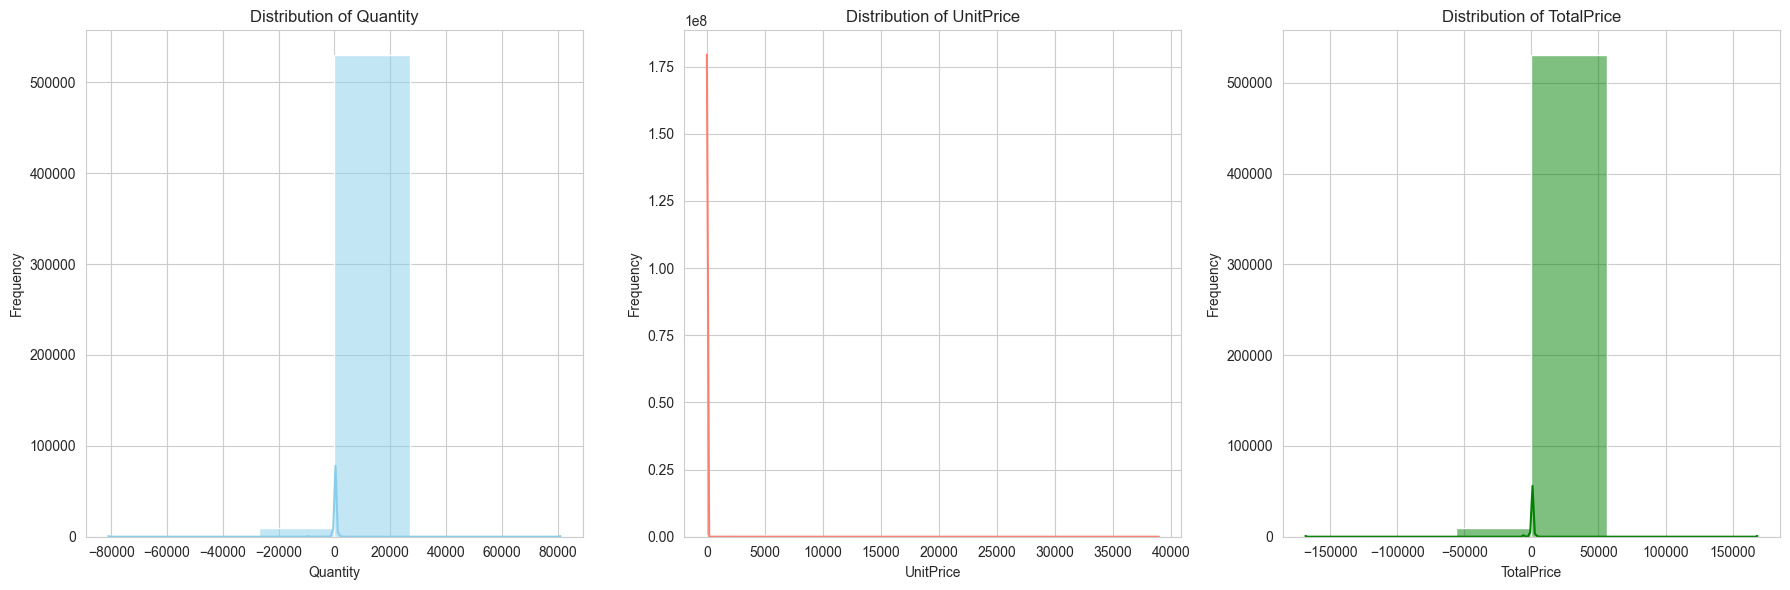

In [10]:
# Distribution of Quantity, UnitPrice, and TotalPrice

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plotting histogram for Quantity
sns.histplot(df['Quantity'], bins=6, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of Quantity')
ax[0].set_xlabel('Quantity')
ax[0].set_ylabel('Frequency')

# Plotting histogram for UnitPrice
sns.histplot(df['UnitPrice'], bins=6, kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribution of UnitPrice')
ax[1].set_xlabel('UnitPrice')
ax[1].set_ylabel('Frequency')

# Plotting histogram for TotalPrice
sns.histplot(df['TotalPrice'], bins=6, kde=True, ax=ax[2], color='green')
ax[2].set_title('Distribution of TotalPrice')
ax[2].set_xlabel('TotalPrice')
ax[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Distribution of Quantity:**
- The majority of the quantities lie close to 0, indicating that most of the transactions involve small quantities of items.
- The presence of long tails, especially on the left, suggests there are transactions with negative quantities, which we've already identified as returns or cancellations.
- The spread on the right suggests that there are also bulk purchases, but these are relatively rare compared to smaller quantity transactions.

**Distribution of UnitPrice:**
- The data is right-skewed, indicating that most products are of lower value, with few products having a higher unit price.
- The majority of the products have a unit price close to 0, suggesting that the store primarily deals with low to mid-priced items.
- There are some products with a higher unit price, but they are outliers and don't represent the general trend.

**Distribution of TotalPrice:**
- The majority of the total transaction values (quantity times unit price) are on the lower side, which is consistent with the observations from the other two histograms.
- The distribution is again right-skewed, indicating that most transactions are of lower value, but there are a few transactions with higher total values.
- As with the Quantity distribution, the left tail indicates transactions with negative total prices, representing returns or cancellations.

**Overall Analysis:**
- The store primarily deals with low to mid-value items, with most transactions involving small quantities.
- Bulk purchases, high-value items, and high total transaction values are less frequent but do occur.
- Returns or cancellations, represented by the negative values in Quantity and TotalPrice, are also a significant aspect of the business, which might warrant further investigation.

---

## 1.1 Distribution of Transactions Over Time

This will help us understand any temporal patterns in the data, such as seasonality, trends, or specific days or months with higher sales.

We'll visualize:
- Transactions over months.
- Transactions over days of the week.
- ransactions over hours of the day.

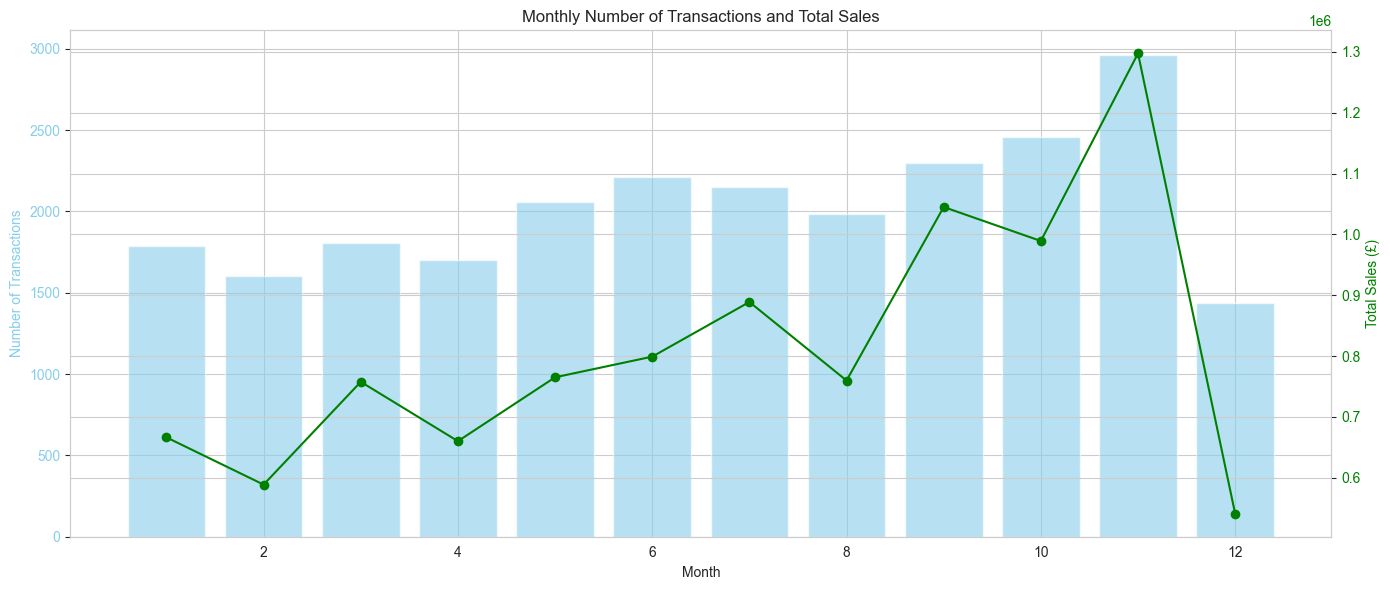

In [11]:
# Grouping data by month
monthly_transactions = df.groupby('Month')['InvoiceNo'].nunique()
monthly_sales = df.groupby('Month')['TotalPrice'].sum()

# Plotting the trends
fig, ax1 = plt.subplots(figsize=(14, 6))

# Twin the axes for two different y-axes
ax2 = ax1.twinx()

# Plotting number of transactions
ax1.bar(monthly_transactions.index, monthly_transactions.values, color='skyblue', alpha=0.6, label='Number of Transactions')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Transactions', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Plotting total sales
ax2.plot(monthly_sales.index, monthly_sales.values, color='green', marker='o', label='Total Sales')
ax2.set_ylabel('Total Sales (£)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Setting the title and showing the plot
plt.title('Monthly Number of Transactions and Total Sales')
fig.tight_layout()
plt.show()

Regular patterns or seasonality in the data suggest that there are recurring events or behaviors influencing sales. Recognizing these patterns can help businesses prepare better — for instance, by stocking up before expected peaks or launching marketing campaigns during lulls to boost sales.

**Peak in November:**
The peak in November can be attributed to events like Black Friday, Cyber Monday, and early Christmas shopping. Promotions or sales during this period can also drive up transactions and sales.

---

## 1.2 Distribution of Transactions by Day of the Week

This can provide insights into customer behavior and help in planning promotions or operations accordingly.

We'll visualize:

- Number of transactions for each day of the week.
- Total sales for each day of the week.


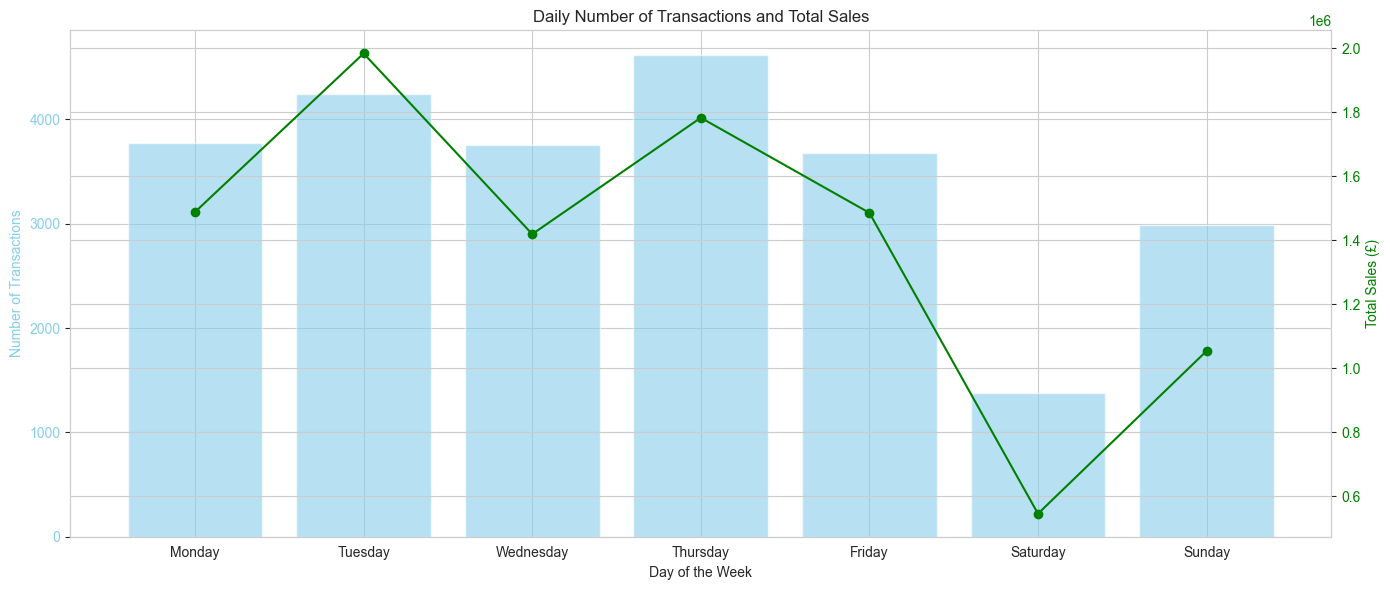

In [12]:
# Grouping data by day of the week
daily_transactions = df.groupby('DayOfWeek')['InvoiceNo'].nunique()
daily_sales = df.groupby('DayOfWeek')['TotalPrice'].sum()

# Days mapping for better visualization
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting the trends
fig, ax1 = plt.subplots(figsize=(14, 6))

# Twin the axes for two different y-axes
ax2 = ax1.twinx()

# Plotting number of transactions
ax1.bar(days, daily_transactions.values, color='skyblue', alpha=0.6, label='Number of Transactions')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Number of Transactions', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Plotting total sales
ax2.plot(days, daily_sales.values, color='green', marker='o', label='Total Sales')
ax2.set_ylabel('Total Sales (£)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Setting the title and showing the plot
plt.title('Daily Number of Transactions and Total Sales')
fig.tight_layout()
plt.show()

- The dip on Saturdays suggests that there's potential to increase sales on this day, given it's typically a busy shopping day. Strategies could include special Saturday promotions or addressing any operational challenges that might exist. Currently, it seems that store has shorter operating hours on Saturdays. <br> <br>

- The high sales on Tuesday, coupled with the second-highest transaction volume, indicates that this day is crucial for revenue. Understanding and potentially amplifying the factors driving these sales could further boost revenue.  <br> <br>

- The high transaction volume on Thursday, despite not being the highest sales day, suggests that this day sees a lot of customer engagement. Strategies could focus on upselling or promoting higher-value items on this day.

---

## 1.3 Distribution of Transactions by Hour of the Day

This provide insights into when customers are most active. This information can be vital for planning flash sales, updating inventory in real-time, or allocating customer service resources.

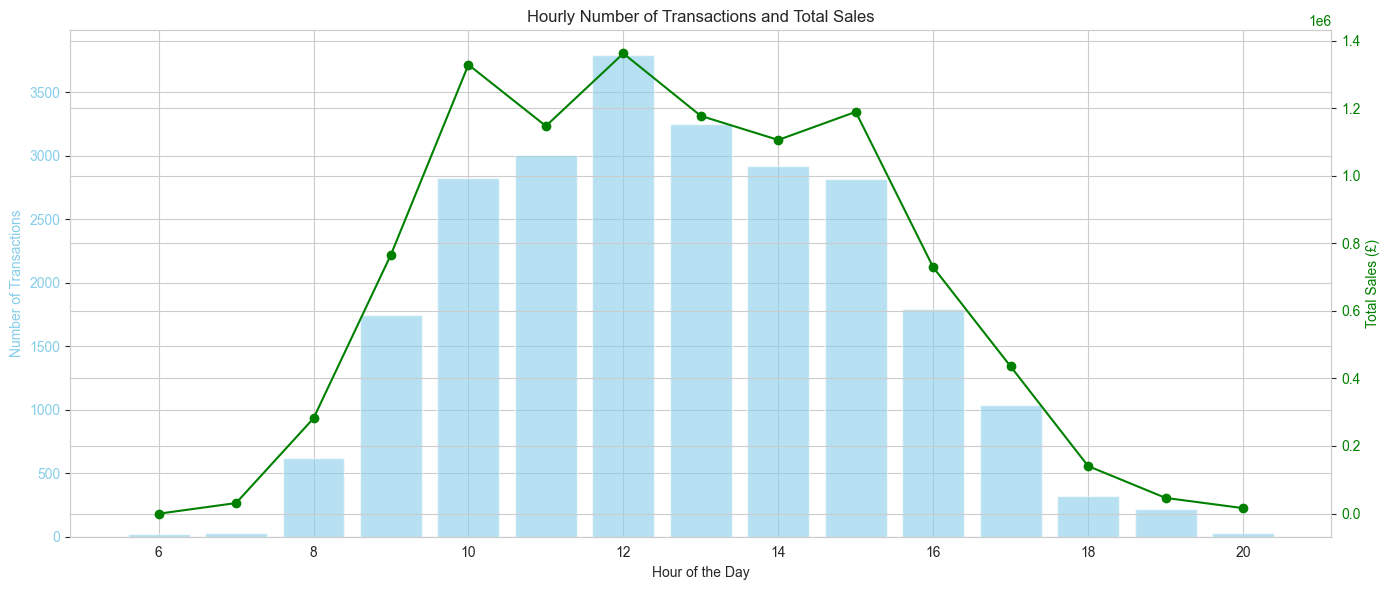

In [13]:
# Grouping data by hour of the day
hourly_transactions = df.groupby('Hour')['InvoiceNo'].nunique()
hourly_sales = df.groupby('Hour')['TotalPrice'].sum()

# Plotting the trends
fig, ax1 = plt.subplots(figsize=(14, 6))

# Twin the axes for two different y-axes
ax2 = ax1.twinx()

# Plotting number of transactions
ax1.bar(hourly_transactions.index, hourly_transactions.values, color='skyblue', alpha=0.6, label='Number of Transactions')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Transactions', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Plotting total sales
ax2.plot(hourly_sales.index, hourly_sales.values, color='green', marker='o', label='Total Sales')
ax2.set_ylabel('Total Sales (£)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Setting the title and showing the plot
plt.title('Hourly Number of Transactions and Total Sales')
fig.tight_layout()
plt.show()

- The peak at 12:00 suggests a potential opportunity to increase sales by promoting higher-value items or combo deals around this time.
- The higher sales value at 15:00, even without a proportional increase in transaction numbers, suggests that strategies employed during this hour are working well. These strategies can potentially be extended to other hours.
- Understanding the specific products or categories that sell well during different times can further optimize inventory and promotions.

---

## 1.4 Analysis by Country

This will provide insights into market penetration, potential growth regions, and customer behavior in various geographical locations.

We'll visualize:

- Number of transactions for each country.
- Total sales for each country.

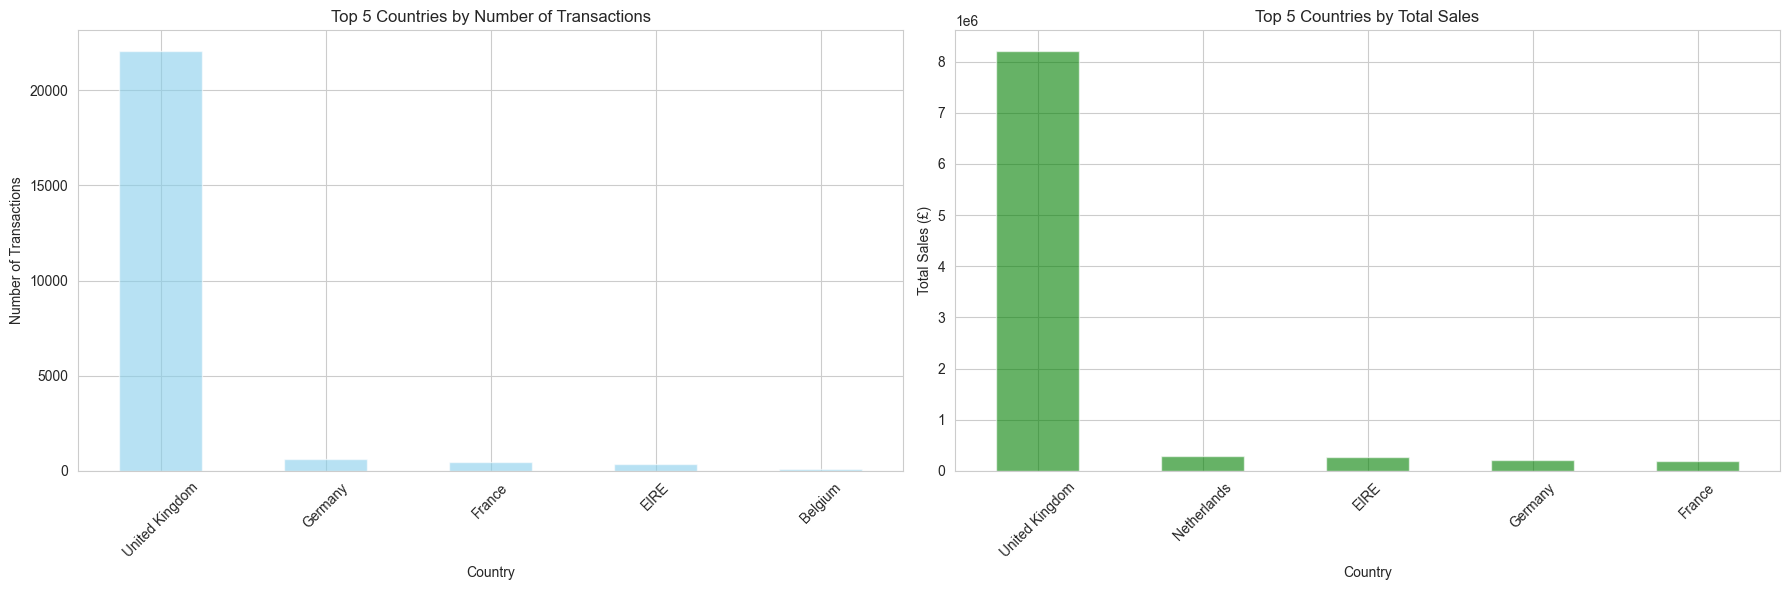

In [14]:
# Grouping data by country
country_transactions = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# Filtering the top 5 countries by transactions and total sales
top5_country_transactions = country_transactions.head(5)
top5_country_sales = country_sales.head(5)

# Plotting the trends side by side for top 5 countries
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plotting number of transactions by country for top 5 countries
top5_country_transactions.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.6)
ax1.set_title('Top 5 Countries by Number of Transactions')
ax1.set_ylabel('Number of Transactions')
ax1.set_xlabel('Country')
ax1.tick_params(axis='x', rotation=45)

# Plotting total sales by country for top 5 countries
top5_country_sales.plot(kind='bar', ax=ax2, color='green', alpha=0.6)
ax2.set_title('Top 5 Countries by Total Sales')
ax2.set_ylabel('Total Sales (£)')
ax2.set_xlabel('Country')
ax2.tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()


The UK having the highest number of sales and transactions is expected since the online retail store is UK-based. 

Ensuring customer retention and expanding the customer base here is crucial. However, tailored marketing campaigns for specific EU countries can help boost sales in those regions.

---

## 1.5 Correlation between numerical variables

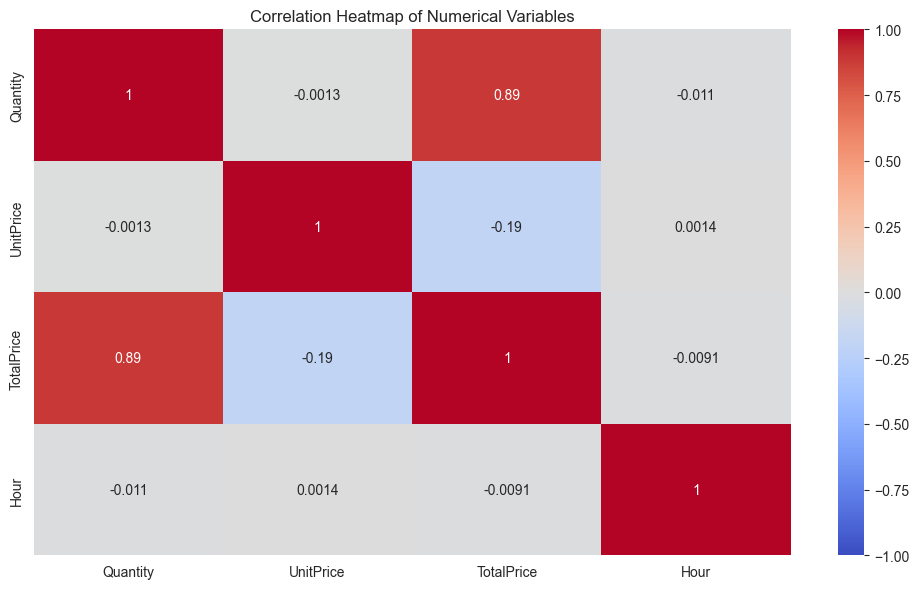

In [15]:
# Computing the correlation matrix
correlation_matrix = df[['Quantity', 'UnitPrice', 'TotalPrice', 'Hour']].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Variables')
plt.tight_layout()
plt.show()


The strong correlation between quantity and total price suggests that volume sales are driving revenue. A pricing strategy that encourages bulk purchases or offers discounts on buying in larger quantities might be effective.

---

# 2. Top Products Analysis

## 2.1 Analysis of Top Products

This can provide insights into inventory management, marketing strategies, and customer preferences.

We'll visualize:

- The top 10 products by number of transactions.
- The top 10 products by total sales.

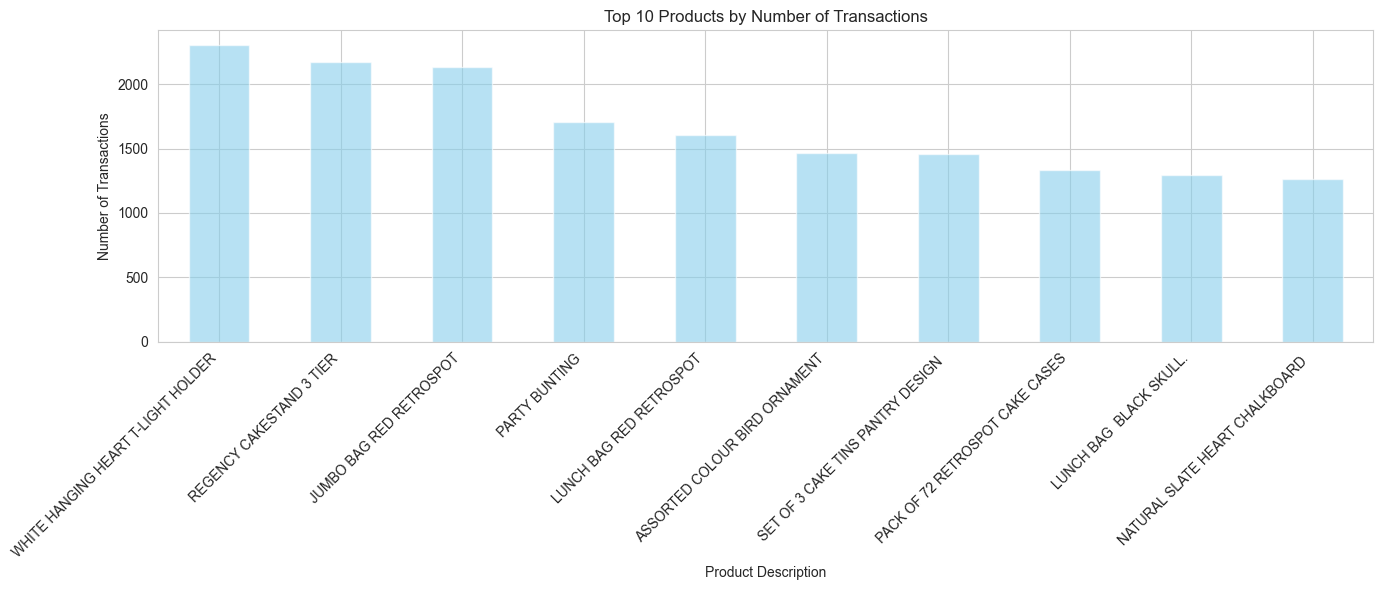

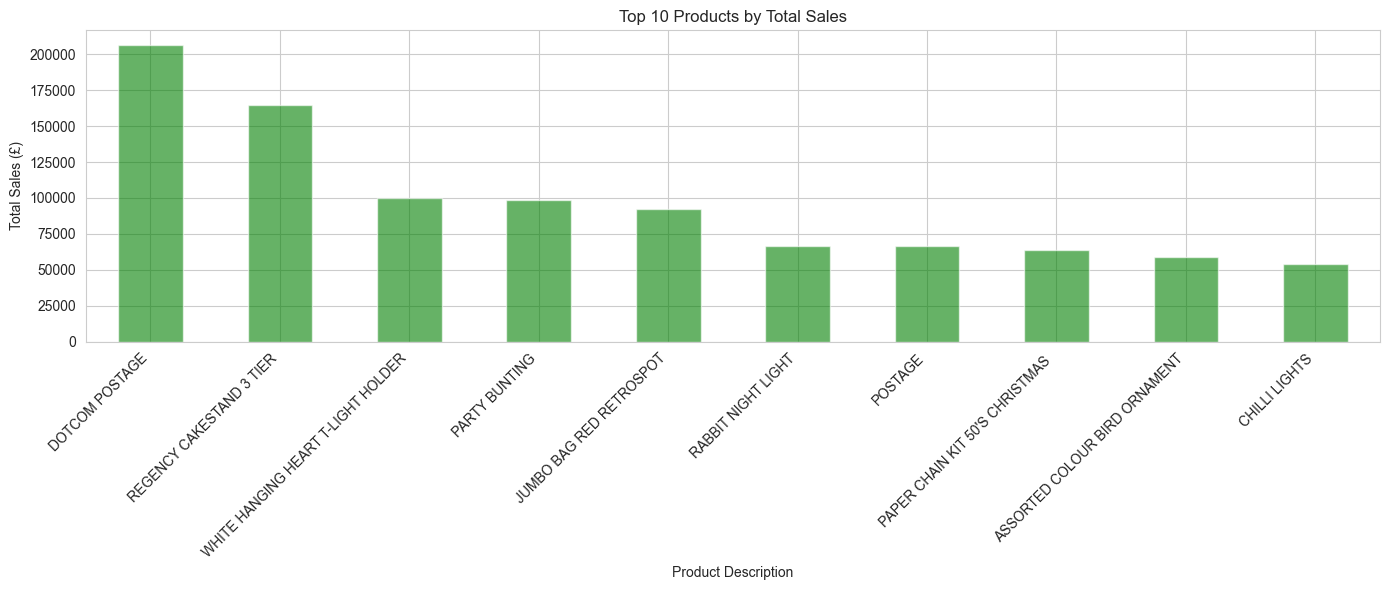

In [16]:
# Grouping data by product description for transactions
product_transactions = df.groupby('Description')['InvoiceNo'].nunique().sort_values(ascending=False).head(10)

# Plotting top products by number of transactions
plt.figure(figsize=(14, 6))
product_transactions.plot(kind='bar', color='skyblue', alpha=0.6)
plt.title('Top 10 Products by Number of Transactions')
plt.ylabel('Number of Transactions')
plt.xlabel('Product Description')
plt.xticks(rotation=45, ha="right")  # Adjusting the x-ticks position with 'ha' parameter
plt.tight_layout()
plt.show()

# Grouping data by product description for sales
product_sales = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

# Plotting top products by total sales
plt.figure(figsize=(14, 6))
product_sales.plot(kind='bar', color='green', alpha=0.6)
plt.title('Top 10 Products by Total Sales')
plt.ylabel('Total Sales (£)')
plt.xlabel('Product Description')
plt.xticks(rotation=45, ha="right")  # Adjusting the x-ticks position with 'ha' parameter
plt.tight_layout()
plt.show()

- Diverse Range: The variety in the top products suggests a diverse customer base with varied interests, from home decor to baking.
- Seasonal Products: Items like the Christmas paper chain kit emphasize the importance of seasonal products.
- Postage & Dotcom Fees: These entries suggest that additional fees or services, like shipping or digital services, can be significant revenue sources.
- Potential Upsells: Popular items like the "WHITE HANGING HEART T-LIGHT HOLDER" can be bundled with related items to increase average transaction value.
- Identifying top-selling products and understanding their appeal can guide marketing campaigns, inventory management, and promotional strategies.

---

## 2.2 Most Sold Products by Quantity

This will provide insights into which products are the most popular among customers based on the volume sold.

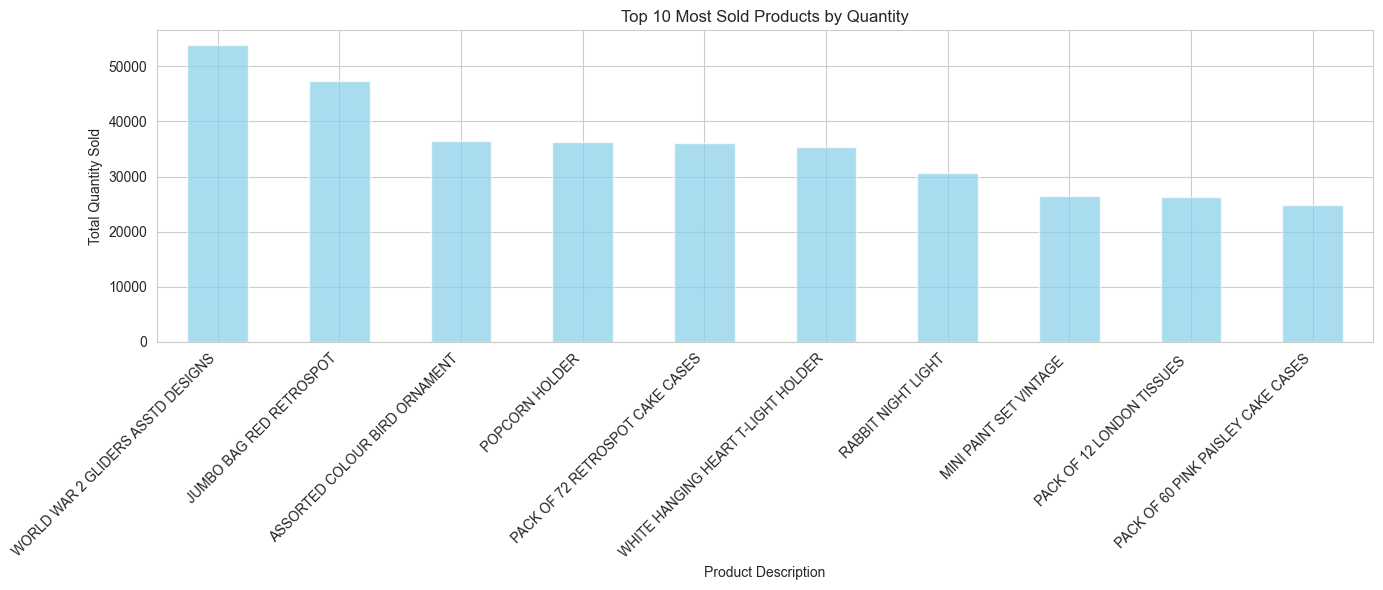

In [17]:
# Grouping products by description and summing up the quantity
most_sold_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Plotting the top 10 most sold products by quantity
plt.figure(figsize=(14, 6))
most_sold_products.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Top 10 Most Sold Products by Quantity')
plt.ylabel('Total Quantity Sold')
plt.xlabel('Product Description')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 2.3 Highest Revenue-Generating Products

This will provide insights into which products contribute the most to the store's revenue.

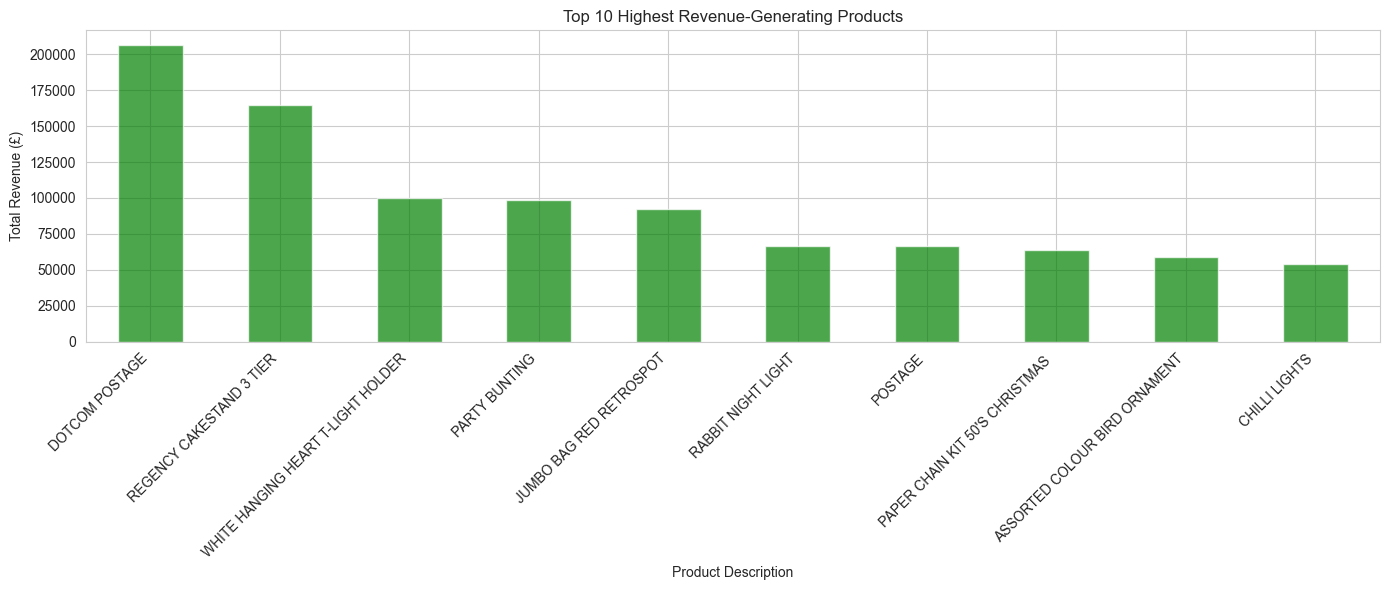

In [18]:
# Grouping products by description and summing up the total price
highest_revenue_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

# Plotting the top 10 highest revenue-generating products
plt.figure(figsize=(14, 6))
highest_revenue_products.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top 10 Highest Revenue-Generating Products')
plt.ylabel('Total Revenue (£)')
plt.xlabel('Product Description')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 3. Customer Analysis

## 3.1 Number of Unique Customers

In [19]:
# Counting the number of unique customers
unique_customers = df['CustomerID'].nunique()
print(f"Total Number of Unique Customers: {unique_customers}")

Total Number of Unique Customers: 4373


## 3.2 Distribution of the Number of Transactions per Customer

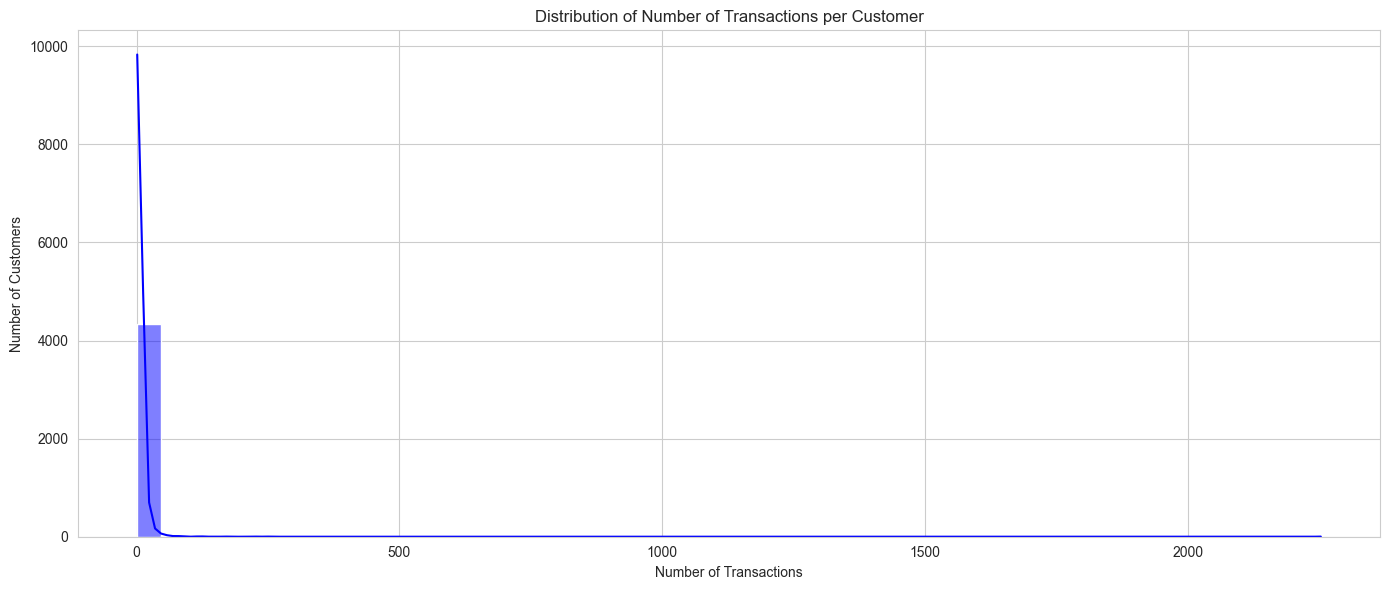

In [20]:
# Grouping data by CustomerID to count the number of transactions per customer
transactions_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Plotting the distribution of transactions per customer
plt.figure(figsize=(14, 6))
sns.histplot(transactions_per_customer, bins=50, color='blue', kde=True)
plt.title('Distribution of Number of Transactions per Customer')
plt.ylabel('Number of Customers')
plt.xlabel('Number of Transactions')
plt.tight_layout()
plt.show()


## 3.3 Distribution of Total Sales per Customer

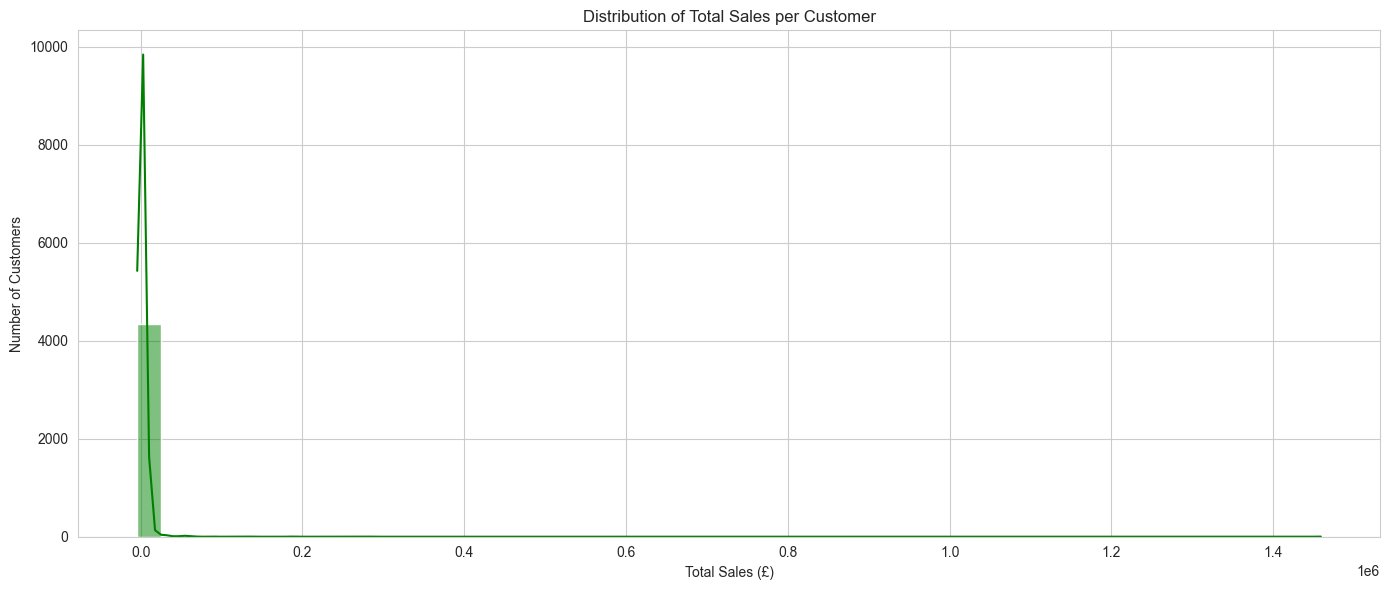

In [21]:
# Grouping data by CustomerID to sum the total sales per customer
sales_per_customer = df.groupby('CustomerID')['TotalPrice'].sum()

# Plotting the distribution of total sales per customer
plt.figure(figsize=(14, 6))
sns.histplot(sales_per_customer, bins=50, color='green', kde=True)
plt.title('Distribution of Total Sales per Customer')
plt.ylabel('Number of Customers')
plt.xlabel('Total Sales (£)')
plt.tight_layout()
plt.show()


# 4. Outliers Analysis

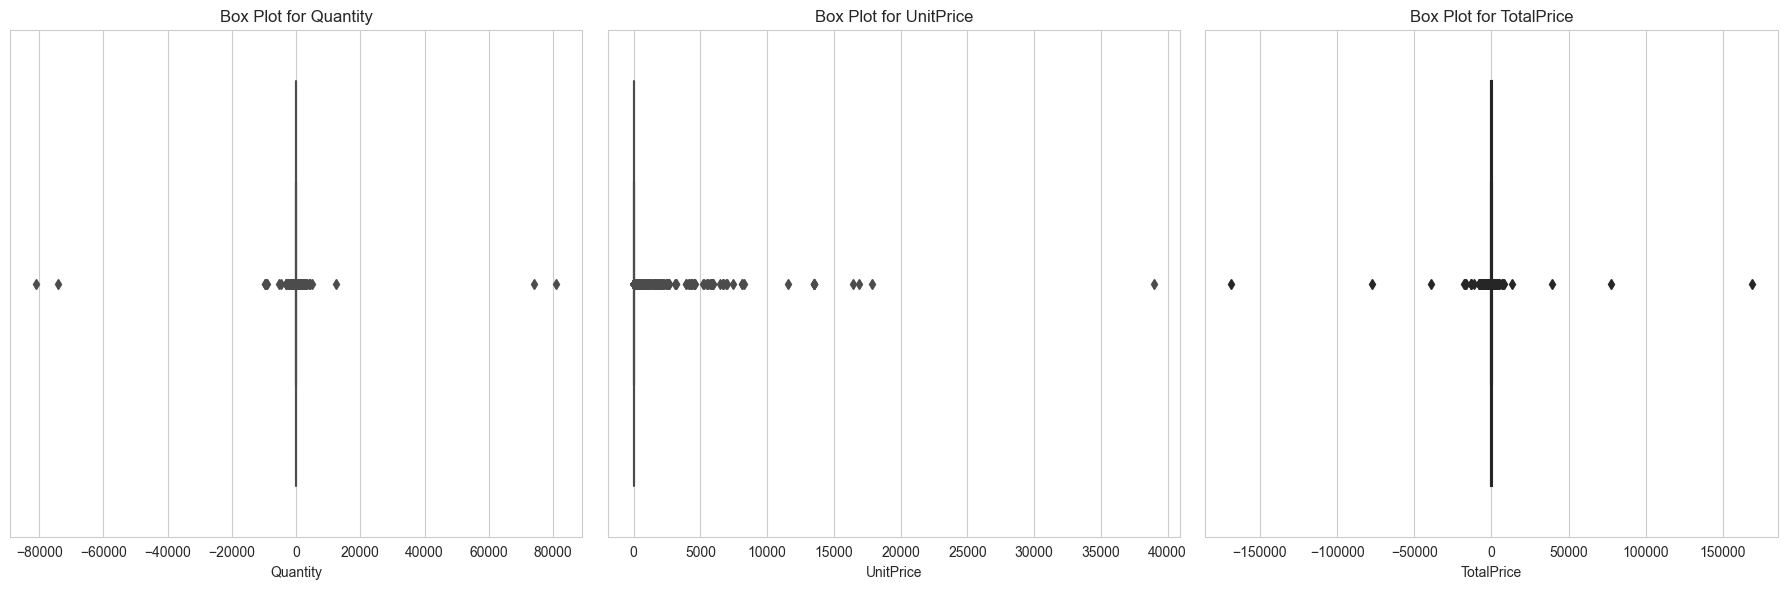

In [22]:
# Setting up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Box Plot for Quantity
sns.boxplot(x=df['Quantity'], ax=axes[0], color='Blue')
axes[0].set_title('Box Plot for Quantity')
axes[0].set_xlabel('Quantity')

# Box Plot for UnitPrice
sns.boxplot(x=df['UnitPrice'], ax=axes[1], color='Red')
axes[1].set_title('Box Plot for UnitPrice')
axes[1].set_xlabel('UnitPrice')

# Box Plot for TotalPrice
sns.boxplot(x=df['TotalPrice'], ax=axes[2], color='Green')
axes[2].set_title('Box Plot for TotalPrice')
axes[2].set_xlabel('TotalPrice')

# Adjusting the layout
plt.tight_layout()
plt.show()

# Data Preprocessing for Modeling

## Feature Scaling

In [23]:
# Selecting features to scale
features = df[['Quantity', 'UnitPrice', 'TotalPrice']]

# Initializing the scaler and transforming the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert scaled features to DataFrame for better visualization and handling
df_scaled = pd.DataFrame(scaled_features, columns=features.columns)
df_scaled.head()

,Quantity,UnitPrice,TotalPrice
0,-0.016528,-0.022440,-0.007285
1,-0.016528,-0.013438,0.006034
2,-0.007354,-0.020296,0.010420
3,-0.016528,-0.013438,0.006034
4,-0.016528,-0.013438,0.006034


## Handling Outliers

In [24]:
# Capping outliers for each feature at the 1st and 99th percentiles
for col in df_scaled.columns:
    lower = df_scaled[col].quantile(0.01)
    upper = df_scaled[col].quantile(0.99)
    df_scaled[col] = np.where(df_scaled[col] < lower, lower, df_scaled[col])
    df_scaled[col] = np.where(df_scaled[col] > upper, upper, df_scaled[col])

---

# Customer Segmentation

## RFM Analysis

RFM stands for Recency, Frequency, and Monetary value. It categorizes customers based on:

- Recency: When was the last time a customer made a purchase?
- Frequency: How often does a customer make a purchase?
- Monetary Value: How much does a customer spend?


In [25]:
# Calculate Recency, Frequency, and Monetary value for each customer

# Recency: Days since last purchase
max_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)  # Using the day after the last transaction in the dataset
df['Recency'] = (max_date - df.groupby('CustomerID')['InvoiceDate'].transform('max')).dt.days

# Frequency: Number of purchases
df['Frequency'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')

# Monetary Value
df['MonetaryValue'] = df.groupby('CustomerID')['TotalPrice'].transform('sum')

# Create the RFM DataFrame
rfm_df = df[['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']].drop_duplicates()
rfm_df.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,17850.0,70,35,5288.63
9,13047.0,48,18,3079.10
26,12583.0,1,18,7187.34
46,13748.0,160,5,948.25
65,15100.0,71,6,635.10


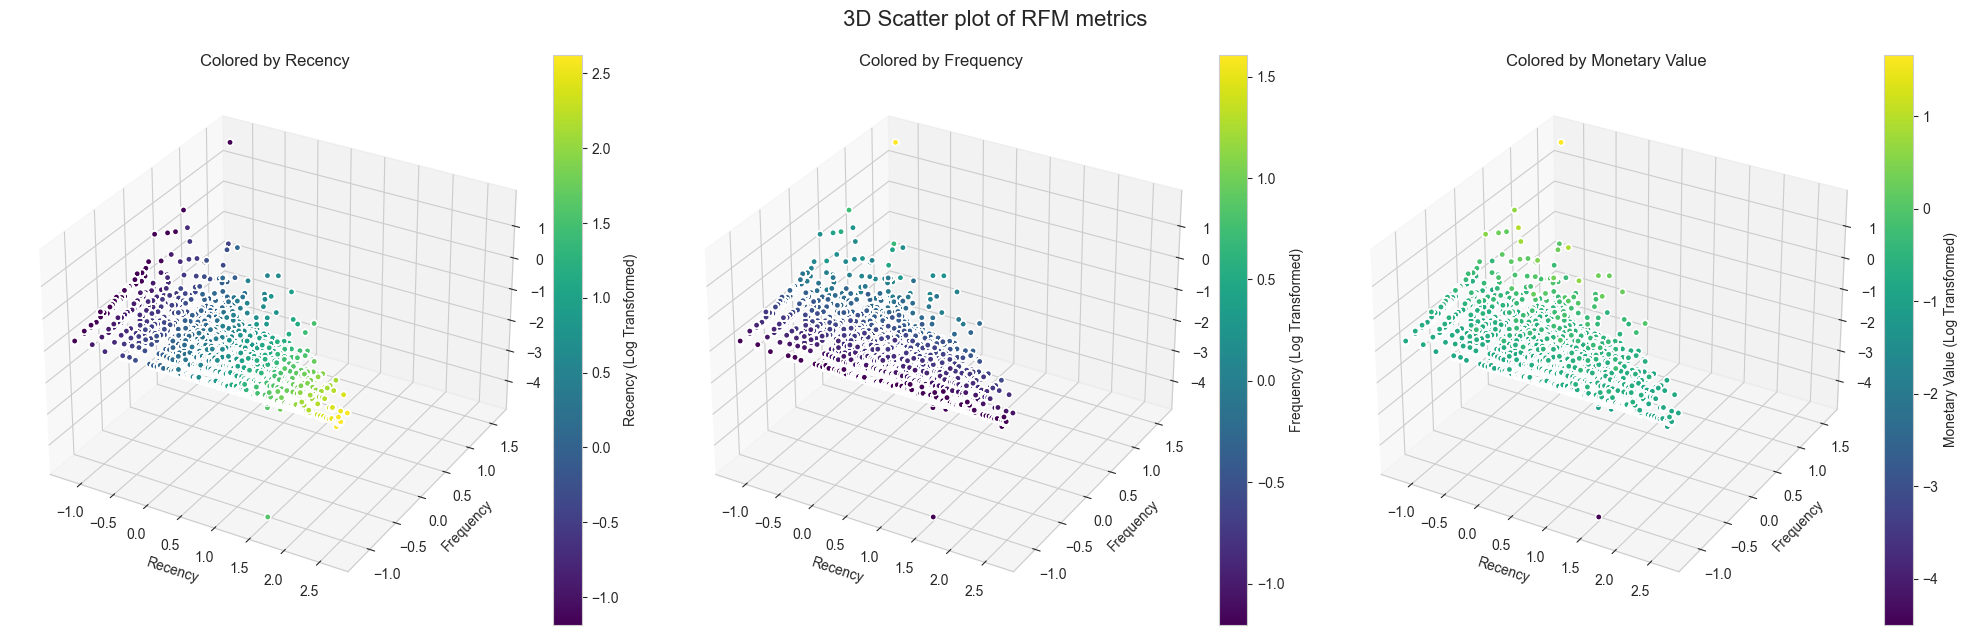

In [26]:
# Code for plotting 3D scatter plots side by side for Recency_log, Frequency_log, and MonetaryValue_log

# Adding a small constant to ensure all values are positive before applying the log transformation
df['Recency_log'] = (df['Recency'] + 1).apply(math.log)
df['Frequency_log'] = (df['Frequency'] + 1).apply(math.log)
df['MonetaryValue_log'] = (df['MonetaryValue'] + abs(df['MonetaryValue'].min()) + 1).apply(math.log)

# Selecting the log-transformed metrics and scaling them
X_subset = df[['MonetaryValue_log', 'Recency_log', 'Frequency_log']]
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
scaled_df = pd.DataFrame(X_scaled, columns=X_subset.columns)
xs = scaled_df['Recency_log']
ys = scaled_df['Frequency_log']
zs = scaled_df['MonetaryValue_log']

fig = plt.figure(figsize=(20, 6))

# Plot for Recency_log
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(xs, ys, zs, c=scaled_df['Recency_log'], s=20, alpha=1.0, edgecolors='w', cmap=plt.cm.viridis)
ax1.set_title('Colored by Recency')
ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.set_zlabel('Monetary Value')
cbar1 = fig.colorbar(scatter1, ax=ax1, orientation='vertical', pad=0.02)
cbar1.set_label('Recency (Log Transformed)')

# Plot for Frequency_log
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(xs, ys, zs, c=scaled_df['Frequency_log'], s=20, alpha=1.0, edgecolors='w', cmap=plt.cm.viridis)
ax2.set_title('Colored by Frequency')
ax2.set_xlabel('Recency')
ax2.set_ylabel('Frequency')
ax2.set_zlabel('Monetary Value')
cbar2 = fig.colorbar(scatter2, ax=ax2, orientation='vertical', pad=0.02)
cbar2.set_label('Frequency (Log Transformed)')

# Plot for MonetaryValue_log
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(xs, ys, zs, c=scaled_df['MonetaryValue_log'], s=20, alpha=1.0, edgecolors='w', cmap=plt.cm.viridis)
ax3.set_title('Colored by Monetary Value')
ax3.set_xlabel('Recency')
ax3.set_ylabel('Frequency')
ax3.set_zlabel('Monetary Value')
cbar3 = fig.colorbar(scatter3, ax=ax3, orientation='vertical', pad=0.02)
cbar3.set_label('Monetary Value (Log Transformed)')

plt.tight_layout()
fig.suptitle('3D Scatter plot of RFM metrics', fontsize=16, y=1.05)
plt.show()

In [27]:
# Given the RFM table, we'll divide it into quartiles.
quantiles = df[['Recency', 'Frequency', 'MonetaryValue']].quantile(q=[0.25, 0.5, 0.75])

# Convert quantiles to a dictionary for easier access
quantiles = quantiles.to_dict()

# Functions to create R, F, M segments
def R_Score(x):
    """Return segment for Recency"""
    if x <= quantiles['Recency'][0.25]:
        return 4
    elif x <= quantiles['Recency'][0.5]:
        return 3
    elif x <= quantiles['Recency'][0.75]:
        return 2
    else:
        return 1

def F_Score(x):
    """Return segment for Frequency"""
    if x <= quantiles['Frequency'][0.25]:
        return 1
    elif x <= quantiles['Frequency'][0.5]:
        return 2
    elif x <= quantiles['Frequency'][0.75]:
        return 3
    else:
        return 4

def M_Score(x):
    """Return segment for MonetaryValue"""
    if x <= quantiles['MonetaryValue'][0.25]:
        return 1
    elif x <= quantiles['MonetaryValue'][0.5]:
        return 2
    elif x <= quantiles['MonetaryValue'][0.75]:
        return 3
    else:
        return 4

# Apply the functions to the RFM table
df['R'] = df['Recency'].apply(lambda x: R_Score(x))
df['F'] = df['Frequency'].apply(lambda x: F_Score(x))
df['M'] = df['MonetaryValue'].apply(lambda x: M_Score(x))

# Calculate the combined RFM score
df['RFM_Segment'] = df['R'].astype(str) + df['F'].astype(str) + df['M'].astype(str)
df['RFM_Score'] = df[['R', 'F', 'M']].sum(axis=1)

In [28]:
df[['Recency','MonetaryValue','Frequency', 'Recency_log', 'MonetaryValue_log','Frequency_log','R','M','F','RFM_Segment','RFM_Score']].head()

,Recency,MonetaryValue,Frequency,Recency_log,MonetaryValue_log,Frequency_log,R,M,F,RFM_Segment,RFM_Score
0,70,5288.63,35,4.26268,9.167147,3.583519,1,3,3,133,7
1,70,5288.63,35,4.26268,9.167147,3.583519,1,3,3,133,7
2,70,5288.63,35,4.26268,9.167147,3.583519,1,3,3,133,7
3,70,5288.63,35,4.26268,9.167147,3.583519,1,3,3,133,7
4,70,5288.63,35,4.26268,9.167147,3.583519,1,3,3,133,7


## Segementation based on RMF

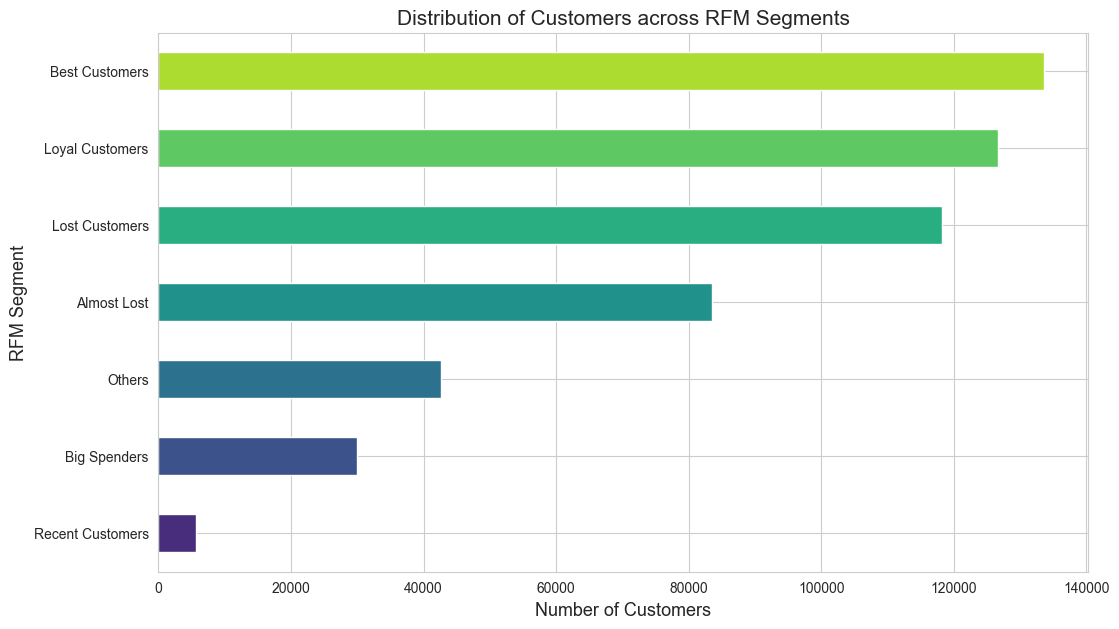

In [29]:
# Define RFM segments based on RFM scores
def rfm_segmentation(row):
    """Function to define RFM segmentation"""
    r, f, m = row['R'], row['F'], row['M']
    
    # Best Customers
    if r == 4 and f == 4 and m == 4:
        return 'Best Customers'
    # Loyal Customers
    elif f >= 3:
        return 'Loyal Customers'
    # Big Spenders
    elif m >= 3:
        return 'Big Spenders'
    # Recent Customers
    elif r == 4:
        return 'Recent Customers'
    # Almost Lost
    elif r == 2 and f <= 2 and m <= 2:
        return 'Almost Lost'
    # Lost Customers
    elif r == 1 and f <= 2 and m <= 2:
        return 'Lost Customers'
    # Lost Cheap Customers
    elif r == 1 and f == 1 and m == 1:
        return 'Lost Cheap Customers'
    else:
        return 'Others'

# Apply the segmentation to the dataframe
df['RFM_Segment_Type'] = df.apply(rfm_segmentation, axis=1)

# Visualizing the distribution of customers across RFM segments
rfm_segment_counts = df['RFM_Segment_Type'].value_counts().sort_values(ascending=True)

# Plotting
fig, ax = plt.subplots(figsize=(12, 7))
rfm_segment_counts.plot(kind='barh', ax=ax, color=sns.color_palette("viridis", len(rfm_segment_counts)))
ax.set_title('Distribution of Customers across RFM Segments', fontsize=15)
ax.set_xlabel('Number of Customers', fontsize=13)
ax.set_ylabel('RFM Segment', fontsize=13)
plt.show()

This initial analysis provides a bird's-eye view of the customer base, highlighting strengths, opportunities, and potential areas for improvement. It sets the stage for deeper dives into specific segments and the formulation of targeted strategies.

---

# K-means Clustering for Segmentation

K-Means clustering is an unsupervised machine learning algorithm used to partition a dataset into K distinct, non-overlapping subsets (or clusters). The goal is to divide data into distinct groups such that observations within each group are similar to each other, while observations across different groups are dissimilar.

**Why use K-Means for Customer Segmentation?**<br>
Customer segmentation aims to divide a diverse customer base into smaller, more similar groups for targeted marketing and service efforts. K-Means provides a data-driven approach to identify these groups based on purchasing behavior or other relevant metrics.

In [30]:
cl = 15
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

# Using X_scaled from our previous segmentations
for k in range(1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++',  # 'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)
    
    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): 
        K_best = k - 1
    cost.append(interia)
    anterior = interia

print('The best K suggested: ', K_best)


The best K suggested:  9


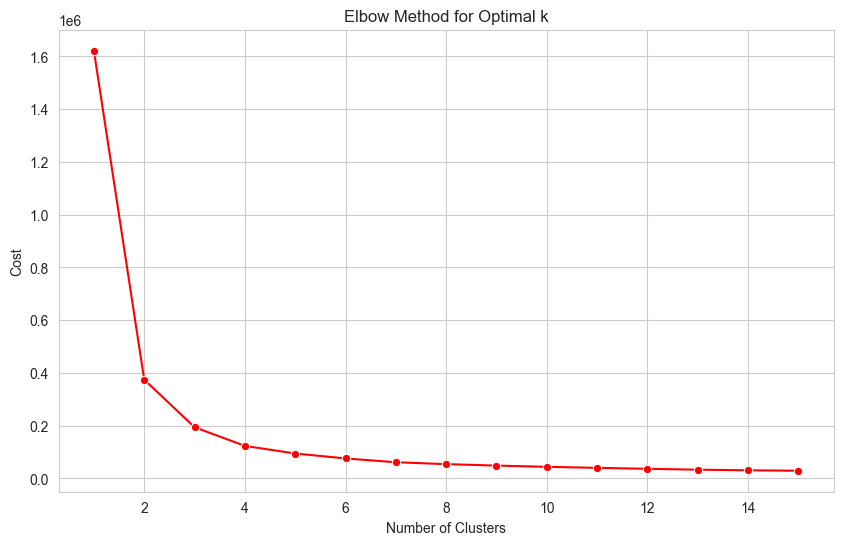

In [31]:
# Plotting using Seaborn
sns.lineplot(x=range(1, cl+1), y=cost, marker='o', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()


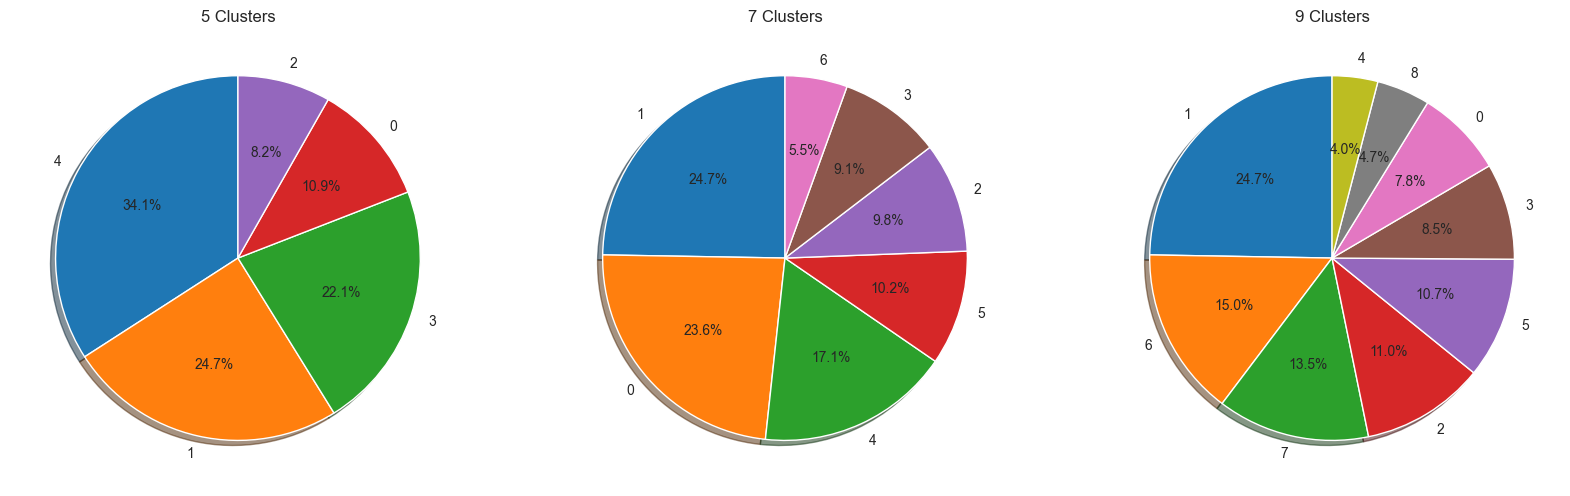

In [32]:
# Assuming that 'X_scaled' and other necessary data is prepared

# Extracting cluster labels for 5, 7, and 9 clusters and adding them to the df
for n_clusters in [5, 7, 9]:
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=101)
    df[f'clusters_{n_clusters}'] = clusterer.fit_predict(X_scaled)

# Visualizing the distribution of data in each cluster using pie charts
fig = plt.figure(figsize=(20, 7))

# 5 Clusters
f1 = fig.add_subplot(131)
market_5 = df.clusters_5.value_counts()
plt.pie(market_5, labels=market_5.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')

# 7 Clusters
f2 = fig.add_subplot(132)
market_7 = df.clusters_7.value_counts()
plt.pie(market_7, labels=market_7.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')

# 9 Clusters
f3 = fig.add_subplot(133)
market_9 = df.clusters_9.value_counts()
plt.pie(market_9, labels=market_9.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('9 Clusters')

plt.show()

**5 Clusters:** Observe the distribution and consider the business implications. For instance, if one cluster is particularly large, it might represent a "general" group of customers with average purchasing behaviors. Smaller clusters might represent niche groups with specific behaviors, like high spenders or very infrequent shoppers.

**7 Clusters:** As you increase the number of clusters, you will likely see more specific niches forming. This might help in targeting very specific user behaviors. However, the challenge is ensuring that these clusters are actionable from a business perspective.

**9 Clusters:** With even more clusters, the granularity increases. While this might provide more insights, it can also lead to challenges in terms of devising specific strategies for each cluster.

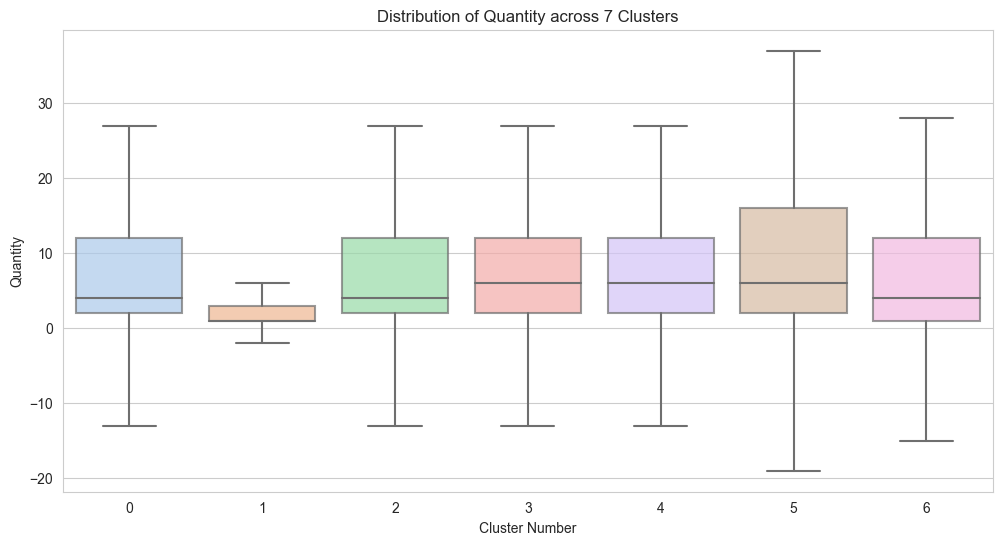

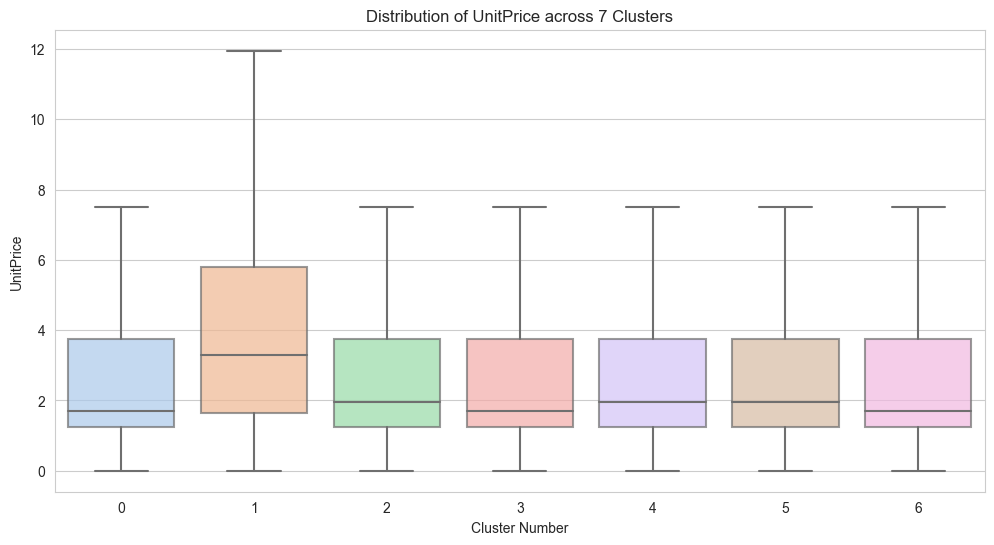

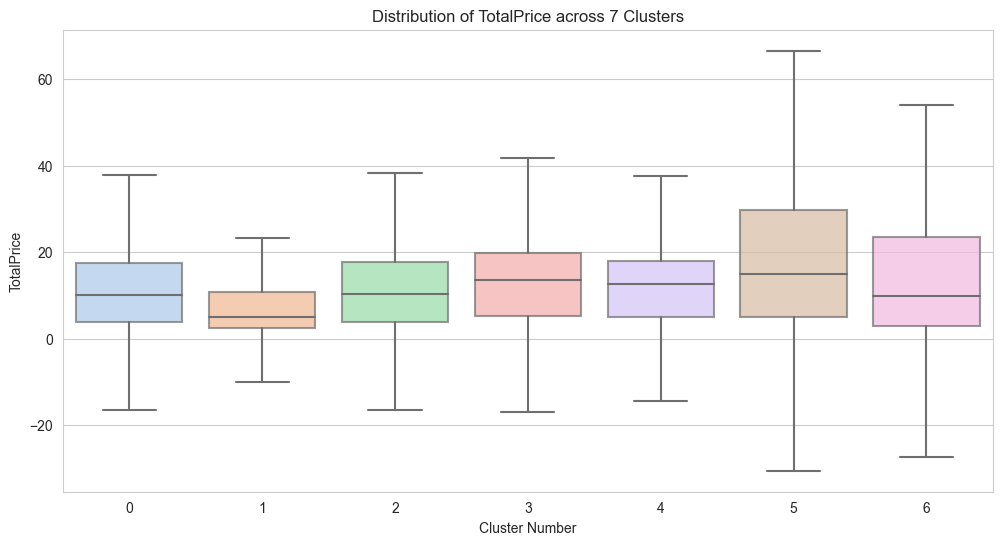

In [33]:
# For 7 clusters
cl = 'clusters_7'

# Loop through each feature and plot the box plot
for field_to_plot in features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=cl, y=field_to_plot, data=df, palette="pastel", boxprops=dict(alpha=.7), showfliers=False)
    plt.title(f'Distribution of {field_to_plot} across 7 Clusters')
    plt.xlabel('Cluster Number')
    plt.ylabel(field_to_plot)
    plt.show()

# Cross Selling Recommendation

The cross selling is the ability to sell more products to a customer by analyzing the customer's shopping trends as well as general shopping trends and patterns which are in common with the customer's shopping patterns. More often than not, these recommended products would be very appealing. The retailer will often offer you a bundle of products with some attractive offer and it is highly likely that we will end up buying the bundled products instead of just the original item.

So, we research the customer transactions and find out potential additions to the customer's original needs and offer it to the customer as a suggestion in the hope and intent that they buy them benefiting both the customer as well as the retail establishment.

In this section, we explore association rule-mining, a powerful technique that can be used for cross selling, then we apply the concept of market basket analysis to our retail transactions dataset.

## Association Rule Mining using Apriori Algorithm

Association Rule Mining is a technique that identifies underlying relations between different items. It uncovers the patterns and relationships between various products by analyzing the transactions made by customers. A classic example is the relationship between diapers and beers, where people who buy diapers often buy beer too.

**Apriori Algorithm** is a popular method used for association rule mining. It operates on a principle that a subset of a frequent itemset must also be a frequent itemset. For instance, if `{Milk, Bread}` is frequent, then `{Milk}` and `{Bread}` should also be frequent.

**Key Concepts:**

1. **Support:** It is the percentage of orders that contain the itemset. For example, if there are 5 transactions out of 100 that contain `Milk` and `Bread`, the support for the itemset `{Milk, Bread}` is 5%.

2. **Confidence:** For a rule `A -> B`, confidence is the percentage of times that item `B` is purchased, given that item A was purchased. It signifies the likelihood of item `B` being purchased when item `A` is purchased.

3. **Lift:** Lift indicates the strength of a rule over the random occurrence of A and B. It basically tells us the strength of any rule. A lift of 1 means there is no association between products A and B. Lift of greater than 1 means products A and B are more likely to be bought together. Finally, lift of less than 1 refers to the items being unlikely bought together.

In [34]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Grouping the data by invoices and products to get the list of products per invoice
grouped_data = df.groupby('InvoiceNo')['Description'].apply(list)

# Using TransactionEncoder to transform the data into a user-item matrix format
te = TransactionEncoder()
te_data = te.fit(grouped_data).transform(grouped_data)
df_encoded = pd.DataFrame(te_data, columns=te.columns_)

# Find frequent itemsets using Apriori algorithm
frequent_itemsets = apriori(df_encoded, min_support=0.02, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the top rules sorted by lift
rules.sort_values('lift', ascending=False).head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
80,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.032075,0.032770,0.02246,0.700255,21.368708,0.021409,3.226844,0.984789
81,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.032770,0.032075,0.02246,0.685393,21.368708,0.021409,3.076620,0.985497
82,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.043243,0.025120,0.02246,0.519395,20.676808,0.021374,2.028442,0.994649
79,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.025120,0.043243,0.02246,0.894137,20.676808,0.021374,9.037669,0.976157
9,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.031297,0.037802,0.02246,0.717647,18.984250,0.021277,3.407784,0.977931


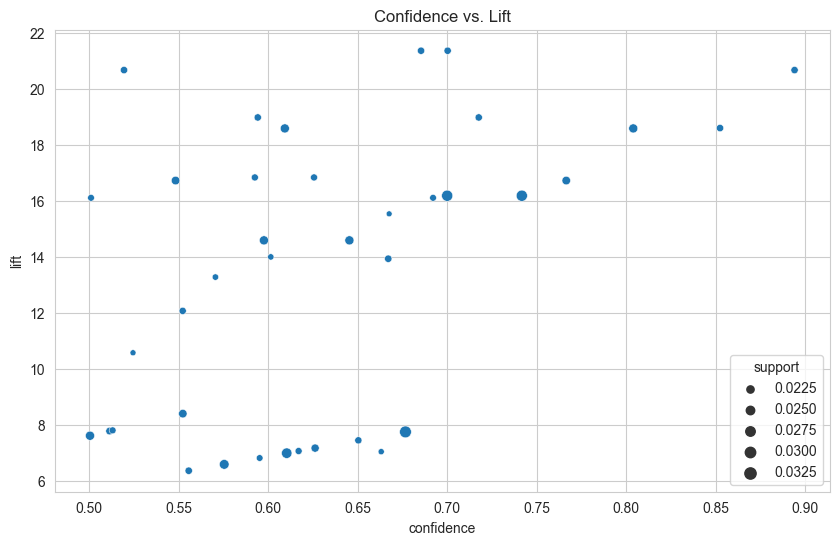

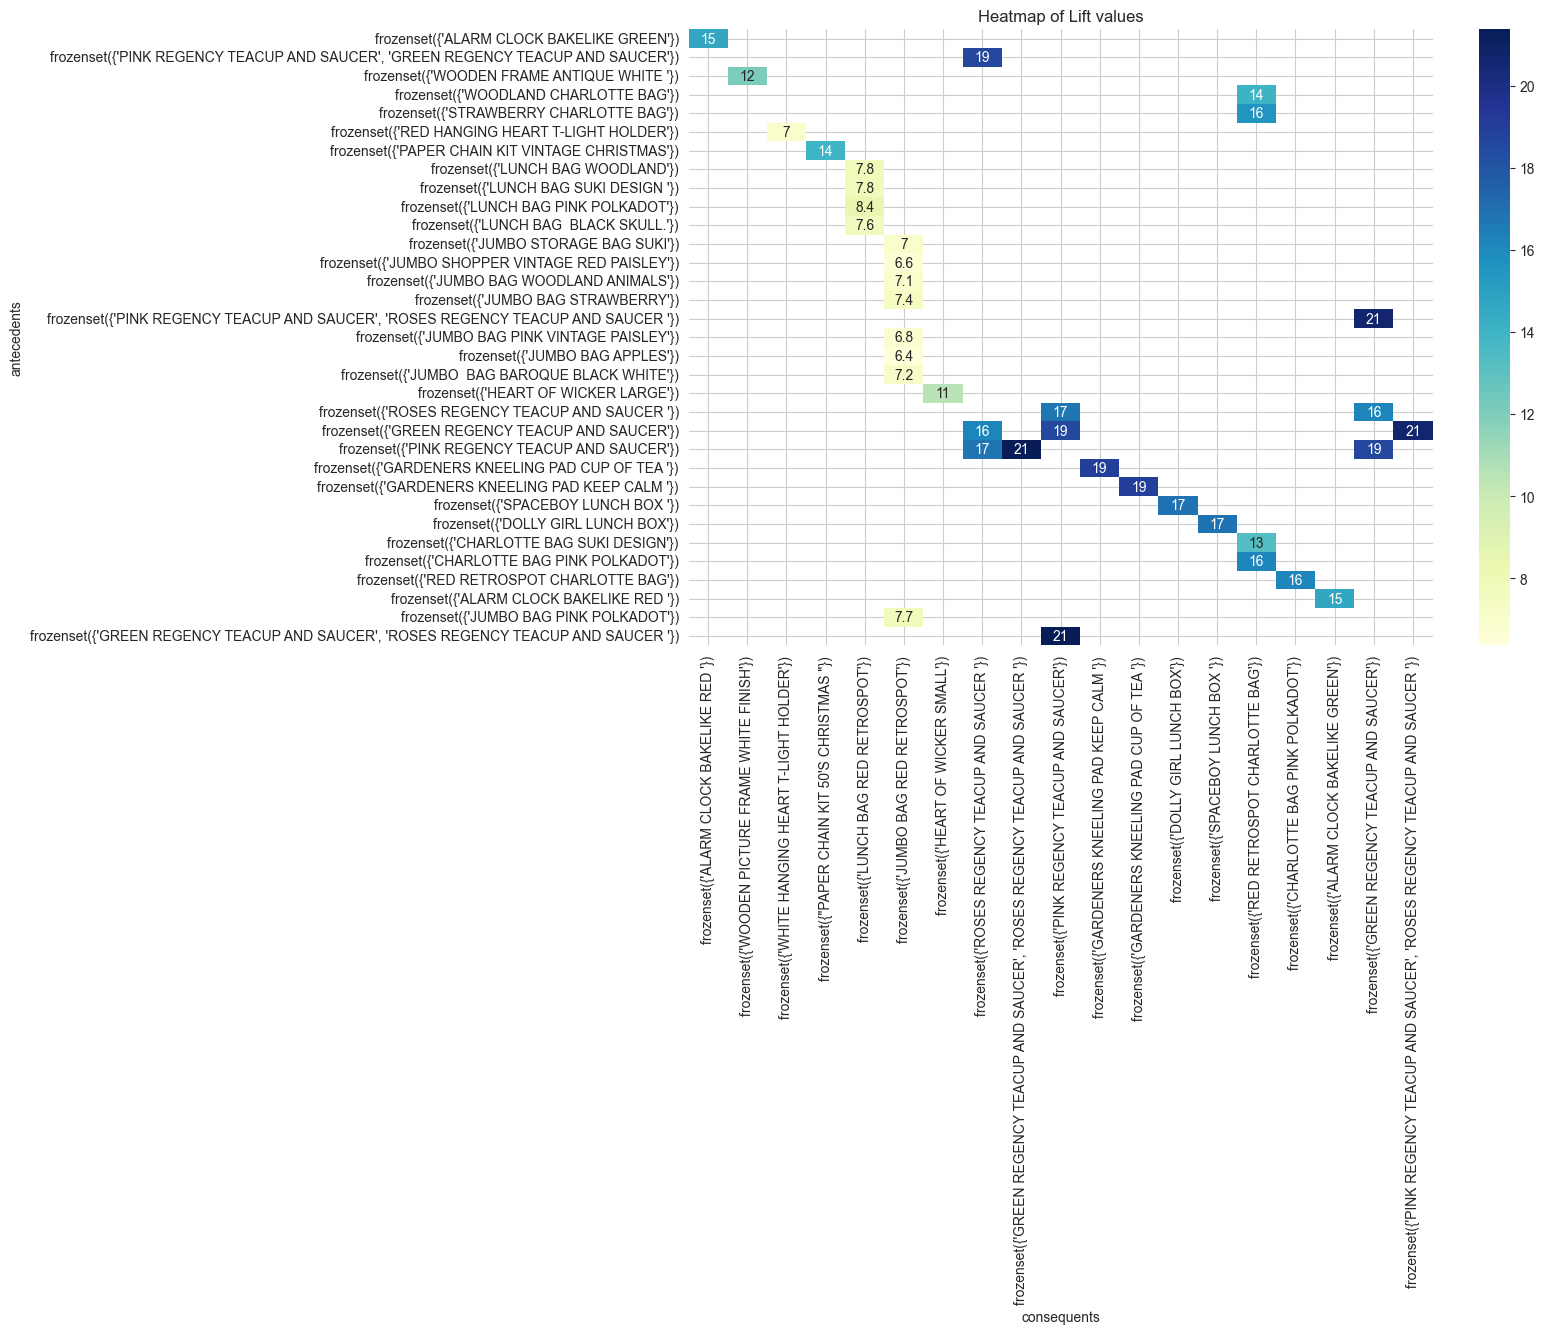

In [35]:
# 1. Filtering the rules
# Here, we are filtering rules with a lift greater than 1 and confidence greater than 0.5
# You can adjust these thresholds based on your needs
filtered_rules = rules[(rules['lift'] > 1) & (rules['confidence'] > 0.5)]

# 2. Visualizing the results
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of confidence vs. lift
plt.figure(figsize=(10, 6))
sns.scatterplot(x="confidence", y="lift", size="support", data=filtered_rules)
plt.title("Confidence vs. Lift")
plt.show()

# You can also use a heatmap to visualize the relationships between items
# For this, you'd need a pivot table of items with lift values
pivot = filtered_rules.pivot(index='antecedents', columns='consequents', values='lift')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, cmap="YlGnBu")
plt.title("Heatmap of Lift values")
plt.show()


In [36]:
# Filtering the rules to get only those with high confidence
high_confidence_rules = rules.sort_values(by="confidence", ascending=False)

# Extracting the top 10 products as antecedents
top_10_products = high_confidence_rules['antecedents'].head(10)

# Lists to store the purchased and recommended products
purchased_products = []
recommended_products = []

for product in top_10_products:
    purchased_products.append(str(product))
    recommended_product = high_confidence_rules[high_confidence_rules['antecedents'] == product]['consequents'].iloc[0]
    recommended_products.append(str(recommended_product))

# Creating a DataFrame
recommendation_df = pd.DataFrame({
    'Purchased Product': purchased_products,
    'Recommended Product': recommended_products
})

# Cleaning up the product names
def clean_product_name(product_name):
    return product_name.replace("frozenset", "").replace("(", "").replace(")", "").replace("{", "").replace("}", "").strip()

recommendation_df['Purchased Product'] = recommendation_df['Purchased Product'].apply(clean_product_name)
recommendation_df['Recommended Product'] = recommendation_df['Recommended Product'].apply(clean_product_name)


In [37]:
recommendation_df

,Purchased Product,Recommended Product
0,"'PINK REGENCY TEACUP AND SAUCER', 'ROSES REGEN...",'GREEN REGENCY TEACUP AND SAUCER'
1,"'PINK REGENCY TEACUP AND SAUCER', 'GREEN REGEN...",'ROSES REGENCY TEACUP AND SAUCER '
2,'PINK REGENCY TEACUP AND SAUCER','GREEN REGENCY TEACUP AND SAUCER'
3,'PINK REGENCY TEACUP AND SAUCER','GREEN REGENCY TEACUP AND SAUCER'
4,'GREEN REGENCY TEACUP AND SAUCER','ROSES REGENCY TEACUP AND SAUCER '
5,'GARDENERS KNEELING PAD CUP OF TEA ','GARDENERS KNEELING PAD KEEP CALM '
6,"'GREEN REGENCY TEACUP AND SAUCER', 'ROSES REGE...",'PINK REGENCY TEACUP AND SAUCER'
7,'ROSES REGENCY TEACUP AND SAUCER ','GREEN REGENCY TEACUP AND SAUCER'
8,'CHARLOTTE BAG PINK POLKADOT','RED RETROSPOT CHARLOTTE BAG'
9,'PINK REGENCY TEACUP AND SAUCER','GREEN REGENCY TEACUP AND SAUCER'
